## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

For each dataset with the similar name 'DATA_01_TYPE01', the ground-truth of heart rate can be
calculated from the simultaneously recorded ECG signal (i.e. the first row of the variable 'sig'). For
convenience, we also provide the calculated ground-truth heart rate, stored in the datasets with the
corresponding name, say 'REF_01_TYPE01'. In each of this kind of datasets, there is a variable 'BPM0',
which gives the BPM value in every 8-second time window. Note that two successive time windows
overlap by 6 seconds. Thus the first value in 'BPM0' gives the calcualted heart rate ground-truth in
the first 8 seconds, while the second value in 'BPM0' gives the calculated heart rate ground-truth
from the 3rd second to the 10th second.

#### Summary of relevant information from the dataset

* **data_fls:** contain the signals recorded
* **ref_fls:** contain the heart rates BPM ground-truth in a 8 sec window with 6sec overlap.
* **Sample rate:** 125 Hz

#### Assumptions

* pulse rate will be restricted between 40BPM (beats per minute) and 240BPM as this is a valid range for heartrate

In [1]:
# Import
import glob

import numpy as np
import scipy as sp
from scipy.io import loadmat
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd
import matplotlib.ticker as plticker


%matplotlib inline


### Code

In [2]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)



### My helper functions

In [3]:
def slice_signals(signals_set, window_s, overlap_s, fs):
    """
        This function slice signals comming from ppg and accelerometer based on the window and overlap selected
        
        @input Args
            - signals_set: array containing ppg, accx, accy, accz signals to be sliced. Signals must be of same size
            - window_s: time frame in [s] to which we will slice our signals
            - overlap_s: time frame in [s] to which we will use to set the stride of the window.
            - fs: Sample rate of the signals
        @output return
            - sliced_signals: ppg, accx,accy,accz sliced signals.
            
    """
    window_sample = int(window_s * fs) # convert window to sample window
    overlap_sample = int(overlap_s * fs) # convert overlap to sample overlap
    window_stride = window_sample-overlap_sample
    sliced_signals = []
    for i in range(0, signals_set.shape[1] - window_sample, window_stride):
        signal_slice = signals_set[:,i:i+window_sample]
        sliced_signals.append(signal_slice)
    return np.array(sliced_signals)

In [4]:
def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    
    @input Args
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    @output returns
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

In [5]:
def spectrogram_slices(signal, window_s, overlap_s, fs, plot=False):
    """
        Computes the spectrogram magnitude of a signal and returns the fft amplitudes and frequencies of it.
        
        @input Args
            signal: (numpy array) signal we want to get the spectrogram from.
            window_s: (float) time frame of the window in seconds
            overlap_s: (float) time frame of the overlap between windows in seconds
            fs: (float) sample rate in Hz
            plot: (Boolean) defines if we want to plot or not plot the spectrogram
        
        @output returns
            spec_amp: (2D numpy array) Amplitudes of the spectrogram per window
            freqs: (numpy array) Frequencies of the spectrogram fow all windows
            
    """
    
    NFFT = fs*window_s # window_s secs to samples
    overlap = fs*overlap_s # overlap_s secs to samples
    time = np.array(range(0,len(signal)))/fs/60 # time in minutes
    if plot:
        #fig=plt.figure(figsize=(15,8))
        spec_amp,  freqs, t, cax= plt.specgram(signal, Fs=fs, NFFT=NFFT, noverlap=overlap, 
                                              scale='linear', mode='magnitude', xextent=(0,time[-1]))
        cbar = plt.colorbar();
        cbar.ax.set_ylabel('Amplitude', rotation=90, labelpad=15, fontsize=20);
        plt.ylim(0,10)
        plt.xlabel('Time [min]', fontsize=20);
        plt.ylabel('frequencies [Hz]', fontsize=20);
        print(f"Shape of the amplitudes in spectrogram {spec_amp.shape} and number of frequencies: {len(freqs)}")
    else:
        fig=plt.figure()
        spec_amp,  freqs, _, _= plt.specgram(signal, Fs=fs, NFFT=NFFT, noverlap=overlap, 
                                              scale='linear', mode='magnitude', xextent=(0,time[-1]))
        plt.close(fig);
    return spec_amp, freqs

In [6]:
def acc_magnitude(accx, accy, accz): 
    """
        Takes accx, accy, accz and returns the magnitude
    """
    return np.sqrt(accx**2+accy**2+accz**2)

In [7]:
def calculate_confidence(amplitudes, frequencies, est_BPM, meas_uncertainty_BPM=0.5):
    """
        Calculates confidence of the measurement based on the amplitude power of the signal
        
        @input Args
            amplitudes: 1D numpy array containing all amplitudes of the signal
            frequencies: 1D numpy array containing all frequencies of the signal, must be same size as amplitudes (Hz)
            est_BPM: Estimated frequency in BPM (float number)
            meas_uncertainty: measurement uncertainty of our estimation in BPM, by default is set 
                              to 0.5 (float number)
        
        @output returns
            confidence: float number that represents how confident our measurement is
    """
    est_Hz = est_BPM/60
    meas_uncertainty_Hz = meas_uncertainty_BPM/60
    uncertainty_window = (frequencies>=est_Hz-meas_uncertainty_Hz) & (frequencies<=est_Hz+meas_uncertainty_Hz)
    confidence = np.sum(amplitudes[uncertainty_window])/np.sum(amplitudes)
    return confidence

In [8]:
def estimation_error(est_BPM, label_BPM):
    """
        Calculates the absolute error of certain estimation
    """
    return np.abs(est_BPM-label_BPM)

In [9]:
def Hz2BPM(value_Hz):
    """
        Converts a value in Hz(hertz) to BPM(beats per minute)
    """
    return value_Hz*60.0

In [10]:
def BPM2Hz(value_BPM):
    """
        Converts a value in BPM(beats per minute) to Hz(hertz)
    """
    return value_BPM/60.0

### Let's visualize the shape for a single dataset

In [11]:
data_fls, ref_fls = LoadTroikaDataset()

In [12]:
sample = 0
# getting signals
signals_set = LoadTroikaDataFile(data_fls[sample]) #signal_set contains: ppg, accx, accy, accz
# getting ground truth 
labels = loadmat(ref_fls[sample])['BPM0']
print(f"shape of ppg signal: {signals_set[0].shape}, accx: {signals_set[1].shape}"
      f", accy: {signals_set[2].shape}, accz: {signals_set[3].shape}, BPM labels: {labels.shape}")

shape of ppg signal: (37937,), accx: (37937,), accy: (37937,), accz: (37937,), BPM labels: (148, 1)


The reason we have more samples in the signal measurements than the labels is because the labels are for a 8 secs window with a 6 secs overlap signals. Therefore we will need to preprocess the signals before creating our model

In [13]:
sliced_signals = slice_signals(signals_set,window_s=8,overlap_s=6,fs=125)
ppg = sliced_signals[:,0,:]
accx = sliced_signals[:,1,:]
accy = sliced_signals[:,2,:]
accz = sliced_signals[:,3,:]
print(f"shape of ppg signal: {ppg.shape}, accx: {accx.shape}"
      f", accy: {accy.shape}, accz: {accz.shape}, BPM labels: {labels.shape}")

shape of ppg signal: (148, 1000), accx: (148, 1000), accy: (148, 1000), accz: (148, 1000), BPM labels: (148, 1)


`comment:`Now we can see that the number of samples of each signal corresponds to the number of labels. Each window has 1000 samples which at a sample rate of 125 [Hz] it is equivalent to 8 secs

### Lets visualize a slice of the PPG signal

In [14]:
# sample rate
fs = 125
#define time vector
time = np.array(range(0,signals_set[0].shape[0]))/fs/60 # time in minutes

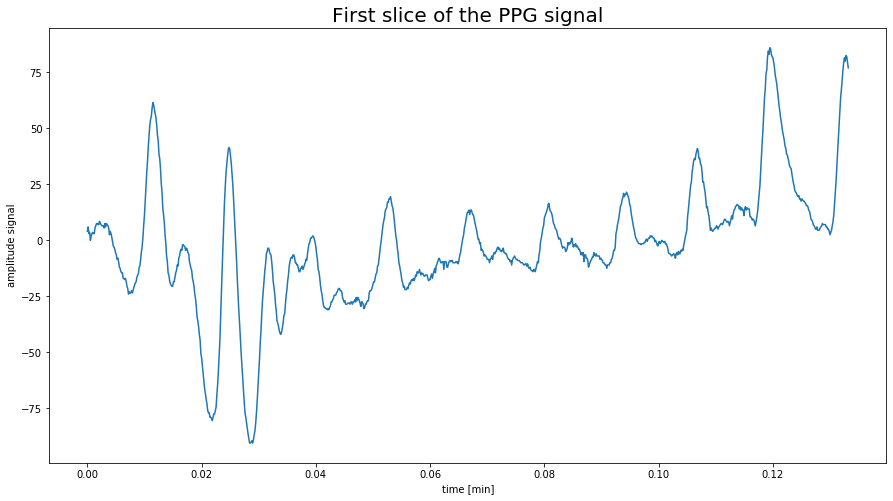

In [15]:
fig=plt.figure(figsize=(15,8))
plt.plot(time[:fs*8], ppg[0])
plt.xlabel('time [min]')
plt.ylabel('amplitude signal')
plt.title('First slice of the PPG signal', fontsize=20);

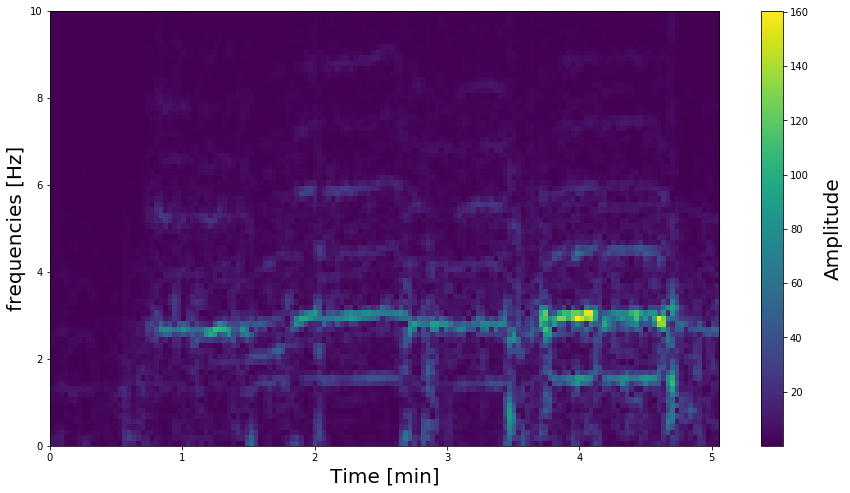

Shape of the amplitudes in spectrogram (501, 148) and number of frequencies: 501


In [16]:
# Plot the whole ppg signal
plt.figure(figsize=(15,8))
NFFT = fs*8 # 8 secs to samples
overlap = fs*6 # 6 secs to samples
whole_ppg_signal = signals_set[0]
spec_amp,  freq, t, cax= plt.specgram(whole_ppg_signal, Fs=fs, NFFT=NFFT, noverlap=overlap, 
                                      scale='linear', mode='magnitude', xextent=(0,time[-1]))
cbar = plt.colorbar();
cbar.ax.set_ylabel('Amplitude', rotation=90, labelpad=15, fontsize=20);
plt.ylim(0,10)
plt.xlabel('Time [min]', fontsize=20);
plt.ylabel('frequencies [Hz]', fontsize=20);
plt.show()
print(f"Shape of the amplitudes in spectrogram {spec_amp.shape} and number of frequencies: {len(freq)}")

`comment:` Here we can see that at the beginning the person is somewhat at rest then it starts moving around minute 0.5 and starts to rest again at minute 4.75

In [17]:
# Calculating the highest frequencies for each window
freq[np.argmax(spec_amp, axis=0)]

array([0.125, 0.125, 0.   , 1.25 , 1.125, 1.125, 1.25 , 0.   , 0.   ,
       1.25 , 1.375, 1.375, 1.25 , 1.125, 1.125, 1.25 , 0.125, 0.125,
       0.125, 0.125, 1.25 , 2.625, 2.75 , 2.625, 2.625, 2.625, 2.625,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 2.5  ,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 0.   ,
       2.75 , 2.75 , 2.75 , 2.75 , 2.125, 2.125, 2.125, 3.25 , 2.625,
       2.75 , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875, 2.875, 2.875,
       2.875, 2.875, 2.875, 2.875, 2.875, 3.   , 3.   , 3.   , 3.   ,
       3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 2.625, 2.75 ,
       2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.625,
       2.625, 2.625, 2.75 , 2.75 , 2.875, 2.75 , 2.75 , 2.75 , 2.75 ,
       2.75 , 2.75 , 0.625, 2.375, 2.375, 0.   , 2.5  , 2.5  , 2.625,
       2.875, 3.   , 2.5  , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875,
       2.875, 3.   , 3.   , 3.   , 2.625, 2.75 , 2.75 , 3.   , 3.   ,
       2.875, 3.   ,

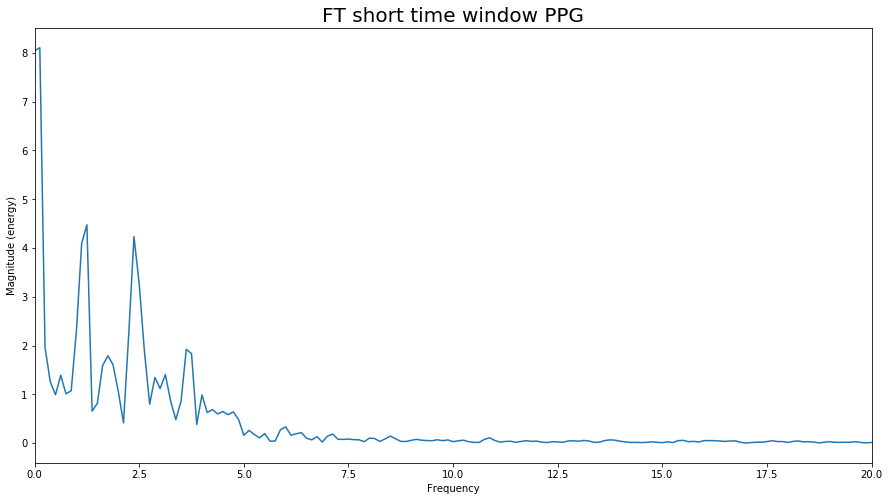

In [18]:
fig=plt.figure(figsize=(15,8))
ax = plt.subplot(111)
plt.magnitude_spectrum(ppg[0],Fs=fs);
plt.title('FT short time window PPG', fontsize=20)
plt.xlim(0,20);

we need to Filter out valid BPM rates for Heart rate. As explained in the beginning 40 BPM to 240 BPM is a coherent range.
 $$[40,240]BPM\equiv [0.667,4] Hz$$

In [19]:
filtered_ppg = BandpassFilter(ppg[0],(0.667,4),fs)

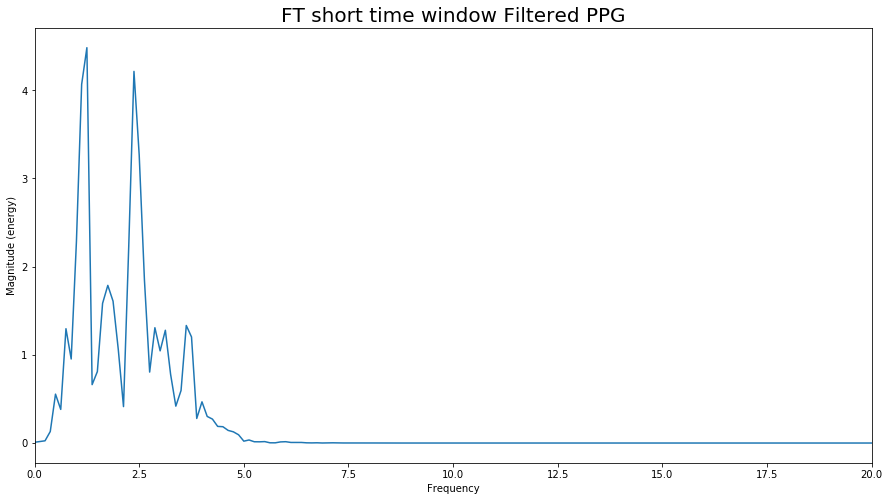

In [20]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
plt.magnitude_spectrum(filtered_ppg,Fs=fs)
plt.title('FT short time window Filtered PPG', fontsize=20)
plt.xlim(0,20);


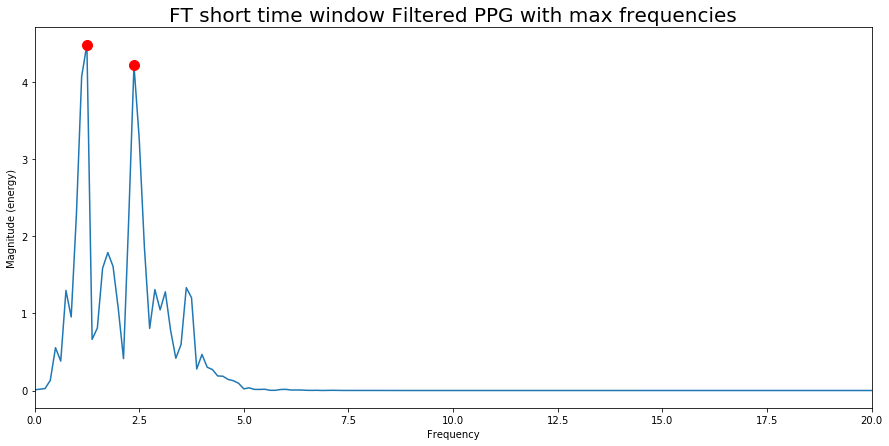

The highest frequencies are: [1.25  2.375] Hz


In [21]:
plt.figure(figsize=(15,7))
ampls, freqs, _ = plt.magnitude_spectrum(filtered_ppg,Fs=fs)
plt.title('FT short time window Filtered PPG with max frequencies', fontsize=20)
pks = sp.signal.find_peaks(ampls, prominence=3, height=2)[0]
plt.plot(freqs[pks], ampls[pks], 'r.', ms=20);
plt.xlim(0,20);
plt.show()
print(f"The highest frequencies are: {freqs[pks]} Hz")

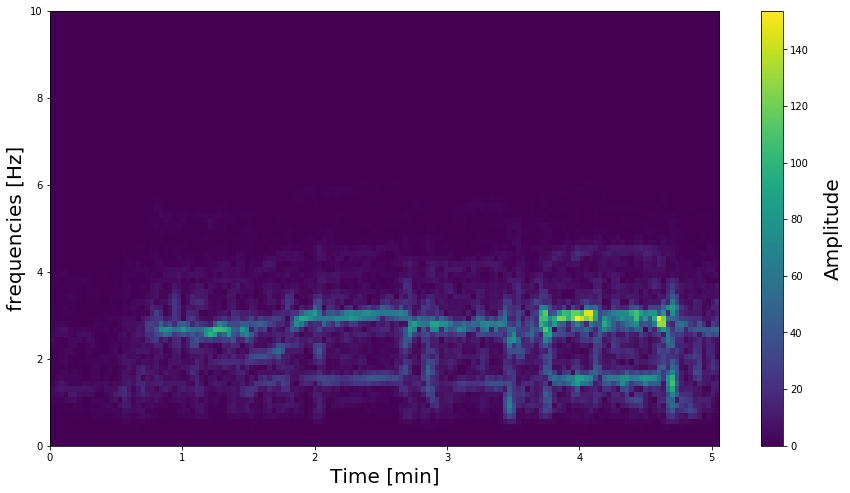

Shape of the amplitudes in spectrogram (501, 148) and number of frequencies: 501


In [22]:
# Lets calculate the spectrogram for the filtered ppg signal
plt.figure(figsize=(15,8))
NFFT = fs*8 # 8 secs to samples
overlap = fs*6 # 6 secs to samples
whole_ppg_signal = signals_set[0]
filtered_ppg = BandpassFilter(whole_ppg_signal, pass_band=(0.667,4), fs=fs)
spec_amp,  freq, t, cax= plt.specgram(filtered_ppg, Fs=fs, NFFT=NFFT, noverlap=overlap, 
                                      scale='linear', mode='magnitude', xextent=(0,time[-1]))
cbar = plt.colorbar();
cbar.ax.set_ylabel('Amplitude', rotation=90, labelpad=15, fontsize=20);
plt.ylim(0,10)
plt.xlabel('Time [min]', fontsize=20);
plt.ylabel('frequencies [Hz]', fontsize=20);
plt.show()
print(f"Shape of the amplitudes in spectrogram {spec_amp.shape} and number of frequencies: {len(freq)}")

In [23]:
# Calculating the highest frequencies for each window
freq[np.argmax(spec_amp, axis=0)]

array([1.25 , 1.25 , 1.25 , 1.25 , 1.125, 1.125, 1.25 , 1.25 , 1.25 ,
       1.25 , 1.375, 1.375, 1.25 , 1.125, 1.125, 1.25 , 1.25 , 1.125,
       1.875, 1.375, 1.25 , 2.625, 2.75 , 2.625, 2.625, 2.625, 2.625,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 2.5  ,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 2.5  ,
       2.75 , 2.75 , 2.75 , 1.375, 2.125, 2.125, 2.125, 2.25 , 2.625,
       2.75 , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875, 2.875, 2.875,
       2.875, 2.875, 2.875, 2.875, 2.875, 3.   , 3.   , 3.   , 3.   ,
       3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 2.625, 2.75 ,
       2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.625,
       2.625, 2.625, 2.75 , 2.75 , 2.875, 2.75 , 2.75 , 2.75 , 2.75 ,
       2.75 , 2.75 , 2.375, 2.375, 2.375, 2.125, 2.5  , 2.5  , 2.625,
       2.875, 3.   , 2.5  , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875,
       2.875, 3.   , 3.   , 3.   , 2.625, 2.75 , 2.75 , 3.   , 3.   ,
       2.875, 1.5  ,

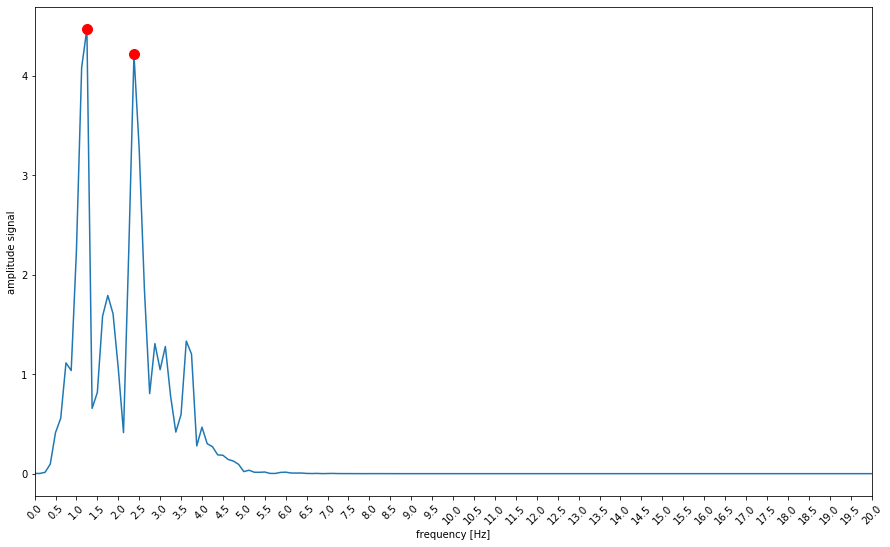

The picks are located at: [1.25  2.375] Hz


In [24]:
## Getting the same results above but using the spectrogram only
whole_ppg_signal = signals_set[0]
filtered_ppg = BandpassFilter(whole_ppg_signal, pass_band=(0.667,4), fs=fs)
ampls, freqs = spectrogram_slices(filtered_ppg,window_s=8,overlap_s=6,fs=fs,plot=False);
# Plot result
plot_window_k = 0
ampl_window_k = ampls[:,plot_window_k]
fig=plt.figure(figsize=(15,9))
ax = plt.subplot(111)
plt.plot(freqs,ampl_window_k)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45); #this rotates the ticks
plt.xlim(0,20)
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude signal')
pks = sp.signal.find_peaks(ampl_window_k, prominence=2)[0]
plt.plot(freqs[pks], ampl_window_k[pks], 'r.', ms=20);
plt.show()
print(f"The picks are located at: {freqs[pks]} Hz")

### Lets visualize the accelerometer signals

In [25]:
accx = signals_set[1]
accy = signals_set[2]
accz = signals_set[3]
## Filtered signals
filtered_accx = BandpassFilter(accx, pass_band=(0.667,4), fs=fs)
filtered_accy = BandpassFilter(accy, pass_band=(0.667,4), fs=fs)
filtered_accz = BandpassFilter(accz, pass_band=(0.667,4), fs=fs)

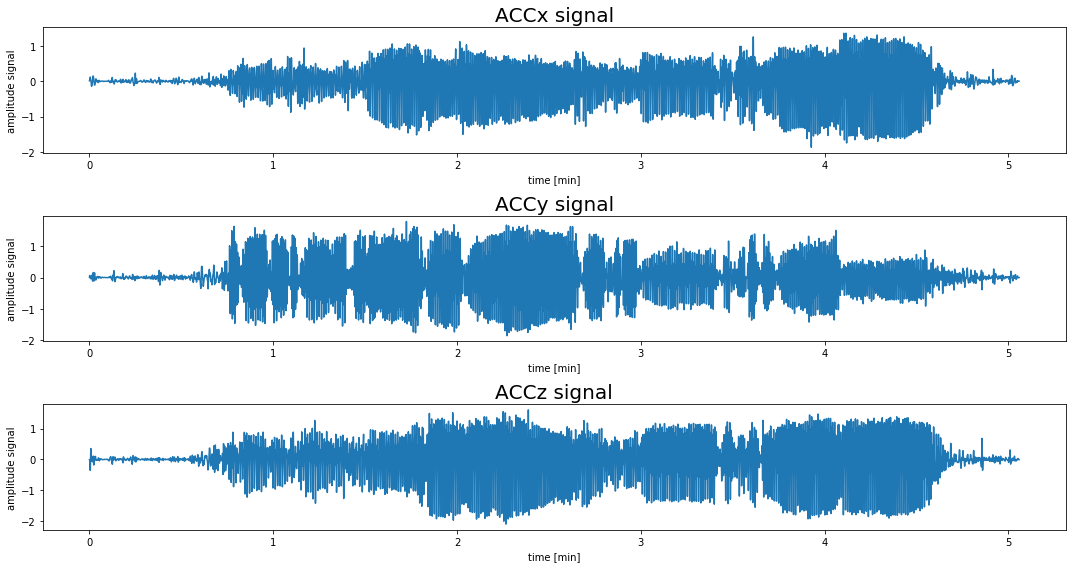

In [26]:
fig=plt.figure(figsize=(15,8))
plt.subplot(311)
plt.plot(time, filtered_accx)
plt.xlabel('time [min]')
plt.ylabel('amplitude signal')
plt.title('ACCx signal', fontsize=20);
plt.subplot(312)
plt.plot(time, filtered_accy)
plt.xlabel('time [min]')
plt.ylabel('amplitude signal')
plt.title('ACCy signal', fontsize=20);
plt.subplot(313)
plt.plot(time, filtered_accz)
plt.xlabel('time [min]')
plt.ylabel('amplitude signal')
plt.title('ACCz signal', fontsize=20);
fig.tight_layout()

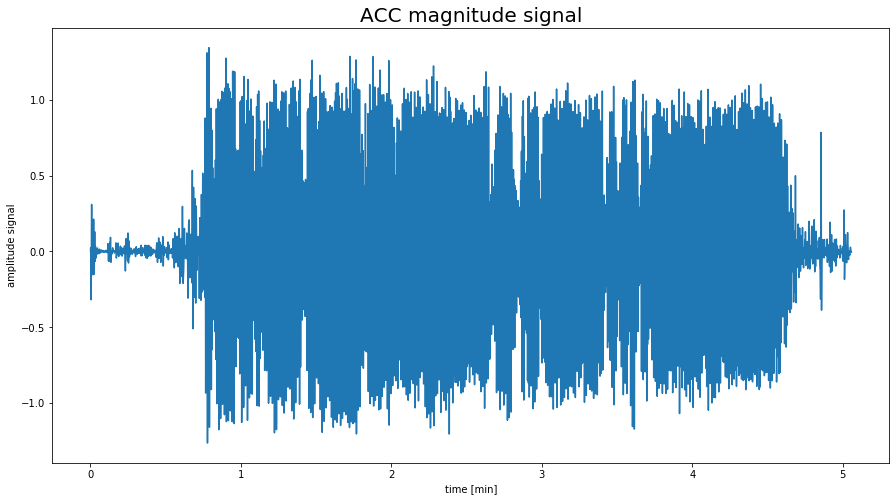

In [27]:
fig=plt.figure(figsize=(15,8))
acc_mag_signal = acc_magnitude(accx, accy, accz)
filtered_acc_mag = BandpassFilter(acc_mag_signal, pass_band=(0.667,4), fs=fs) 
plt.plot(time, filtered_acc_mag)
plt.xlabel('time [min]')
plt.ylabel('amplitude signal')
plt.title('ACC magnitude signal', fontsize=20);

Shape of the amplitudes in spectrogram (501, 148) and number of frequencies: 501
Shape of the amplitudes in spectrogram (501, 148) and number of frequencies: 501
Shape of the amplitudes in spectrogram (501, 148) and number of frequencies: 501


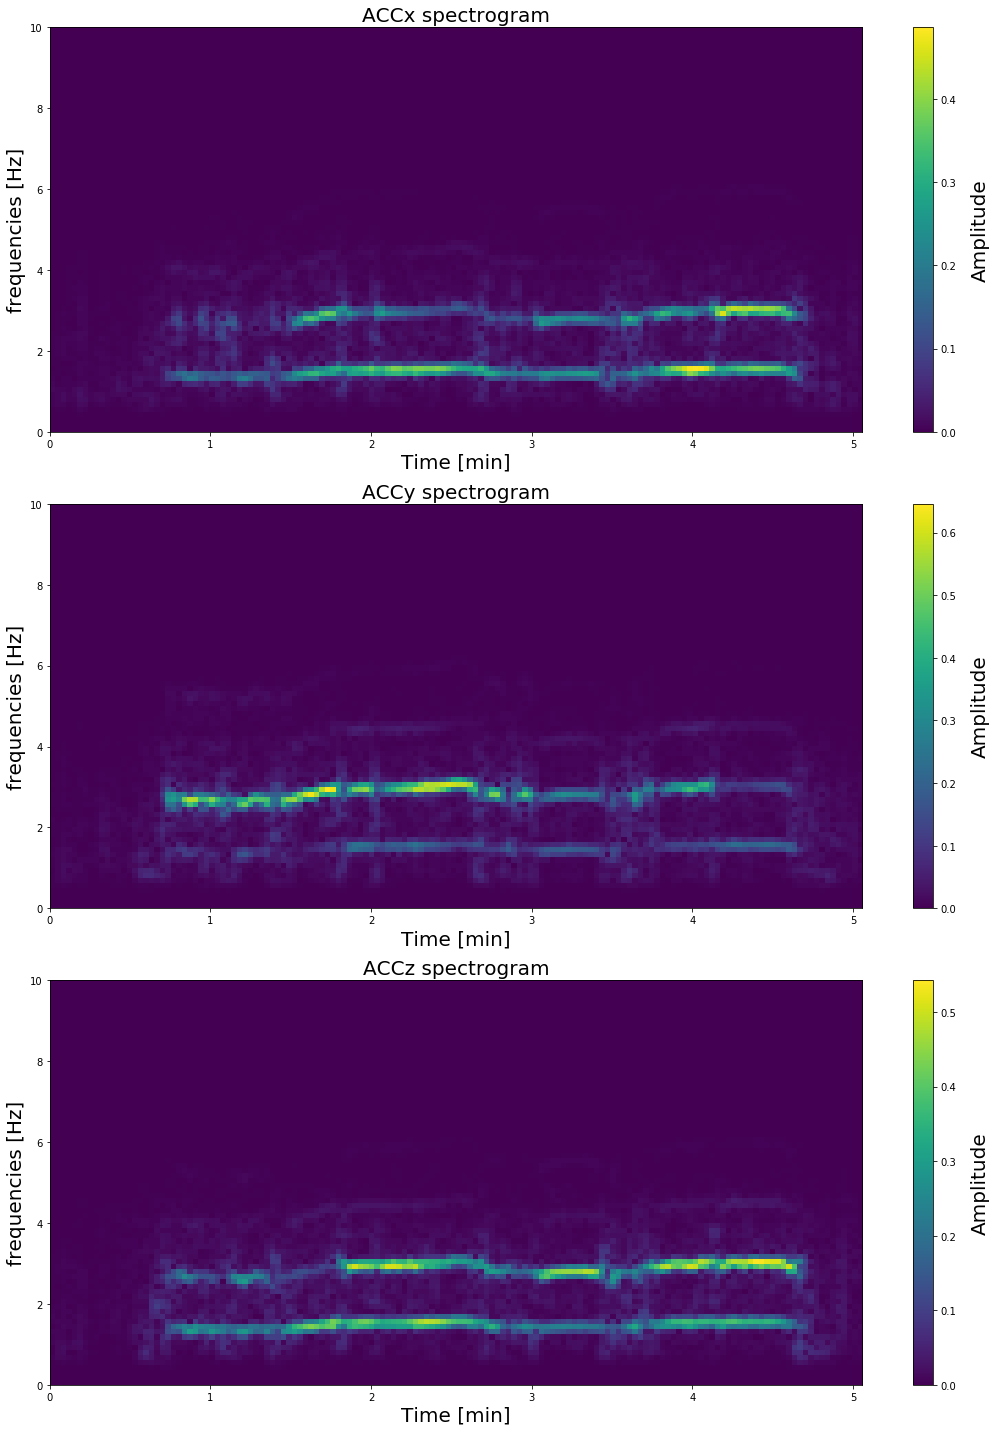

In [28]:
fig=plt.figure(figsize=(15,20))
plt.subplot(311)
spectrogram_slices(filtered_accx,window_s=8,overlap_s=6,fs=fs,plot=True);
plt.title('ACCx spectrogram', fontsize=20);
plt.subplot(312)
spectrogram_slices(filtered_accy,window_s=8,overlap_s=6,fs=fs,plot=True);
plt.title('ACCy spectrogram', fontsize=20);
plt.subplot(313)
spectrogram_slices(filtered_accz,window_s=8,overlap_s=6,fs=fs,plot=True);
plt.title('ACCz spectrogram', fontsize=20);
fig.tight_layout()

Shape of the amplitudes in spectrogram (501, 148) and number of frequencies: 501


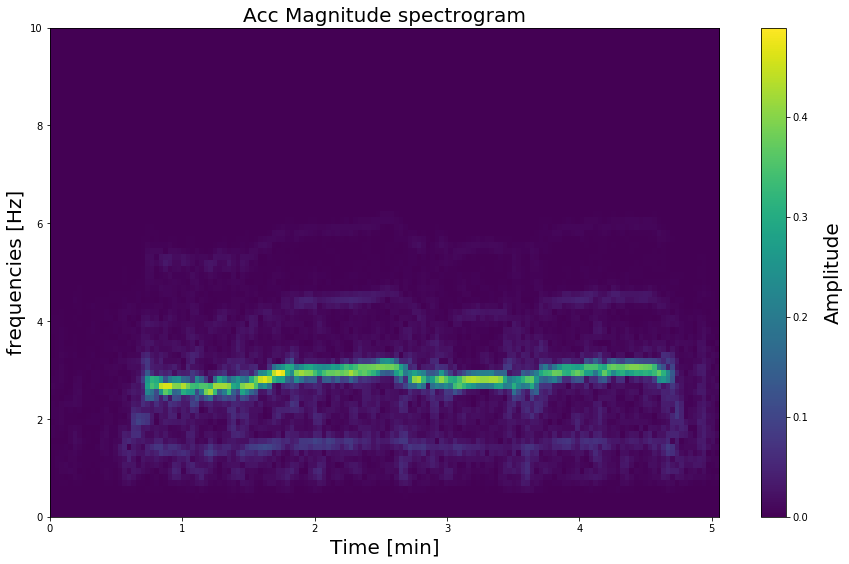

In [29]:
fig=plt.figure(figsize=(15,9))
acc_mag_signal = acc_magnitude(accx, accy, accz)
filtered_acc_mag = BandpassFilter(acc_mag_signal, pass_band=(0.667,4), fs=fs)                            
ampls, freqs = spectrogram_slices(filtered_acc_mag,window_s=8,overlap_s=6,fs=fs,plot=True);
plt.title('Acc Magnitude spectrogram', fontsize=20);

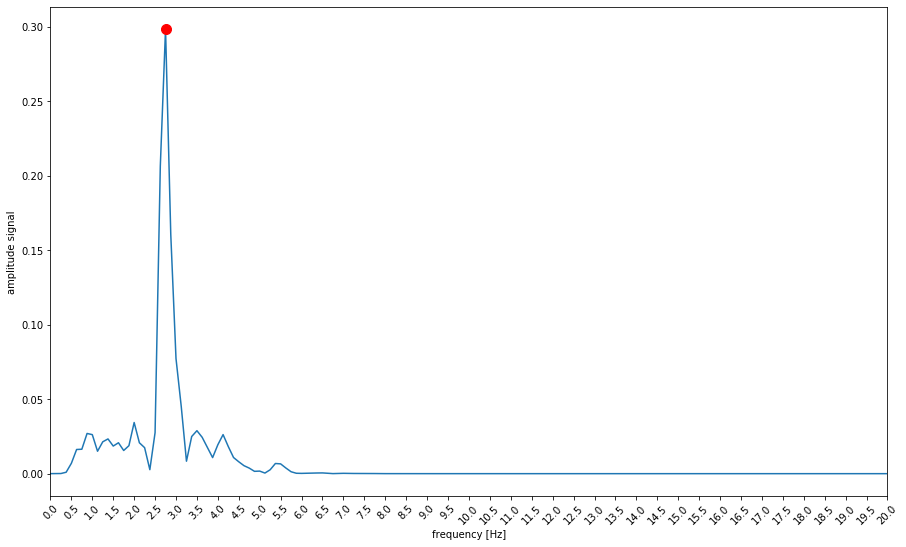

The highest amplitude is at frequency: 2.75


In [30]:
plot_window_k = 100
ampl_window_k = ampls[:,plot_window_k]
fig=plt.figure(figsize=(15,9))
ax = plt.subplot(111)
plt.plot(freqs,ampl_window_k)
loc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45); #this rotates the ticks
plt.xlim(0,20)
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude signal')
pks = sp.signal.find_peaks(ampl_window_k, prominence=0.1, height=0.1)[0]
plt.plot(freqs[pks], ampl_window_k[pks], 'r.', ms=20);
plt.show()
print(f"The highest amplitude is at frequency: {freqs[np.argmax(ampl_window_k)]}")

# Final algorithm

In [114]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Run Pulse Rate Algorithm estimator based on ppg and acc signal
       
    @input Args:
        data_fl: (string) Path to data file (.mat)
        ref_fl: (string) Path to reference data file (.mat)
        log_vars: (bool) If True, log some variables in the `log` object for further analysis
        
    @ Output Returns:
        errors: (np.array) Error scores
        confidence: (np.array) Confidence rates
    """
    
    ## Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    # getting ground truth 
    labels = loadmat(ref_fl)['BPM0']
    
    ## Parameters
    # sample rate
    fs = 125 # given by the dataset provider in Hz
    # define time vector
    time = np.array(range(0,ppg.shape[0]))/fs/60 # time in minutes
    # define tolerance to check for similarity between ppg and acc in frequency domain
    tolerance = 0.2 #Hz
        
    ## Compute pulse rate estimates and estimation confidence.

    # Filtering signals
    filtered_ppg = BandpassFilter(ppg, pass_band=(0.667,4), fs=fs)
    acc_magnitude_signal = acc_magnitude(accx, accy, accz)
    filtered_acc = BandpassFilter(acc_magnitude_signal, pass_band=(0.667,4), fs=fs)
    
    # Compute the spectrogram of both signals
    ampls_pgg, freqs_ppg = spectrogram_slices(filtered_ppg, window_s=8, overlap_s=6, fs=fs, plot=False)
    ampls_acc, freqs_acc = spectrogram_slices(filtered_acc, window_s=8, overlap_s=6, fs=fs, plot=False)
    
    
    errors=[]
    confidence=[]
    
    for window_i in range(ampls_pgg.shape[1]):

        # Getting the window i amplitudes
        ampl_ppg_i = ampls_pgg[:,window_i]
        ampl_acc_i = ampls_acc[:,window_i]
        
        # Find peaks on frequency domain of both ppg and acc       
        pks_ppg_i = sp.signal.find_peaks(ampl_ppg_i, prominence=0.5*np.max(ampl_ppg_i))[0]
        pks_acc_i = sp.signal.find_peaks(ampl_acc_i, prominence=0.1*np.max(ampl_acc_i))[0]
        
        # Getting top frequencies
        ppg_top_freqs = freqs_ppg[pks_ppg_i]
        acc_top_freqs = freqs_acc[pks_acc_i]

        try:
            est_heart_rate = ppg_top_freqs[0] #won't change if arm motion is equal to heart beat frequency
        except:
            break
        for ppg_top_freq in ppg_top_freqs:
            if not any(abs(ppg_top_freq-acc_top_freqs)<tolerance):
                est_heart_rate = ppg_top_freq
                break
        error_est_i = estimation_error(Hz2BPM(est_heart_rate), labels[window_i])
        confidence_i = calculate_confidence(ampl_ppg_i, freqs_ppg, Hz2BPM(est_heart_rate), meas_uncertainty_BPM=0.5)

        errors.append(error_est_i)
        confidence.append(confidence_i)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.mean(errors), np.mean(confidence)  # Dummy placeholders. Remove
    return errors, confidence

In [115]:
Evaluate()

32.97935551902783

---
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 